# Playing with images
This notebook is sandbox of my attemps what is effectient way to concat **read partially** images. 

After I get list of required images for concatination I need to find:
-  Deal with simple way how to cut in one image (no overlapping with other nearest 1x1 km images) 
-  The way how is efficient to read images partially (Which image's edge should I cut? Left-top, right-bottom etc? How?).
-  If i have time deal with no found case, black image as well (in case of no available images).
-  Partially generated image with black tiles (not all tiles are found, so i need to paste black tiles next to it)/

In [ ]:
# Imports
import logging

import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.windows import from_bounds
import pathlib
from pathlib import Path
from PIL import Image
import numpy as np
from pyproj import Transformer
import re
from os import path
from typing import Dict, List
from typing import List, Tuple

from utils import (
    convert_epsg_4326_to_epsg_25832,
    convert_epsg_25832_to_epsg_4326,
    get_bounding_box,
    is_bbox_intersects,
)

from main import get_paths_of_tile_images
import copy


# Typing
Latitude = float
Longitude = float

LatitudeLeft = float
LongitudeBottom = float
LatitudeRight = float
LatitudeTop = float

In [3]:
log = logging.getLogger(__name__)
logging.basicConfig(
    format="[%(asctime)s] [%(levelname)s] %(message)s", level=logging.DEBUG
)

In [4]:
DATASET_DIRECTORY = (
    "/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw"
)

## Simple case (coordinates in middle of one big jp2 image)
I picked randomly image that has clothes 1x1 km images. Lets play with it!  

Coordinate locates in the middle of 'dop10rgbi_32_468_5772_1_nw_2022' image.
Expected to provide 1 tile  (cutted  in the middle 'dop10rgbi_32_468_5772_1_nw_2022' image)

In [5]:
latitude = 8.54010563577907
longitude = 52.10215462837978
radius = 100

log.info("Deal with 'dop10rgbi_32_468_5772_1_nw_2022' image")

latitude, longitude = convert_epsg_4326_to_epsg_25832(
    latitude=latitude, longitude=longitude
)

latitude_left = latitude - radius
longitude_bottom = longitude - radius
latitude_right = latitude + radius
longitude_top = longitude + radius

log.info(
    f"latitude_left {latitude_left}, longitude_bottom {longitude_bottom},\n "
    f"latitude_right {latitude_right}, longitude_top {longitude_top}"
)
tile_image_paths = get_paths_of_tile_images(
    (latitude_left, longitude_bottom, latitude_right, longitude_top),
    Path(DATASET_DIRECTORY),
)

log.info(tile_image_paths)

[2025-01-13 16:46:47,672] [INFO] Deal with 'dop10rgbi_32_468_5772_1_nw_2022' image


[2025-01-13 16:46:47,704] [INFO] latitude_left 468400.0, longitude_bottom 5772400.0,
 latitude_right 468600.0, longitude_top 5772600.0
[2025-01-13 16:46:47,706] [INFO] Found 1 tile(s) intersecting the required area.
[2025-01-13 16:46:47,707] [INFO] [PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2')]


Now lets cut this final image bbox in the middle of one iamge and send back 256x256 image and compare with [https://epsg.io/](https://epsg.io/map#srs=25832&x=468400.0&y=5772400.0&z=17&layer=satellite)

---

Looks fine, but my image a little bit more right, than epsg.io. Look images below. This thing I gues not so critical, but still problem. But know lets gocus on main goal: concat images and finally finish pipeline!

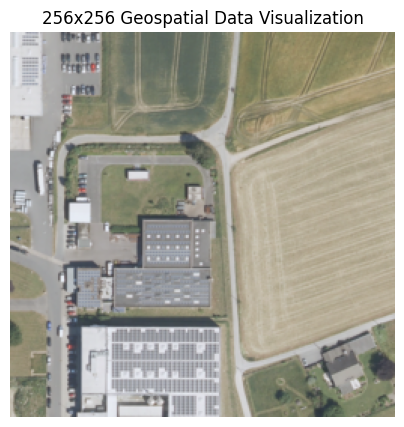

In [6]:
with rasterio.open(tile_image_paths[0]) as src:
    window = from_bounds(
        latitude_left,
        longitude_bottom,
        latitude_right,
        longitude_top,
        transform=src.transform,
    )

    partial_rgb = src.read([1, 2, 3], window=window)
    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_rgb = np.clip(partial_rgb, 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(partial_rgb, mode="RGB")
    pil_img_256 = pil_img.resize((256, 256), resample=Image.BILINEAR)

    # Plot the data
    plt.figure(figsize=(5, 5))
    plt.imshow(pil_img_256)
    plt.title("256x256 Geospatial Data Visualization")
    plt.axis("off")
    plt.show()

More right than point. Is it because I didn't calculate final image bound box correct? For example, point of left bottom of this image? Anyway I will check it later.
![Image from epsg.io](./docs/screenshot-468400-5772400.png)


## Complicated case (point at the corner of jp2 image)

Now lets try to determine which image corner should I read partially and borders.  

Basically, we have all 4 points of final image format. However the question is: what would happen if I send out bbox that is out of image (will `rasterio` handle the case or raise an error?):
-  In case of error, I can calculate left, bottom, right, top of tile image to cut - open only part of it cut and continue

Let's check first!

---

Coordinate locates at the corner of 'dop10rgbi_32_468_5772_1_nw_2022' image. Should be 4 tiles that I need to concat. Expected to provide 4 tiles. 

In [7]:
latitude, longitude = 468002, 5772002

latitude_left = latitude - radius
longitude_bottom = longitude - radius
latitude_right = latitude + radius
longitude_top = longitude + radius

log.info(
    f"latitude_left {latitude_left}, longitude_bottom {longitude_bottom},\n "
    f"latitude_right {latitude_right}, longitude_top {longitude_top}"
)
tile_image_paths = get_paths_of_tile_images(
    (latitude_left, longitude_bottom, latitude_right, longitude_top),
    Path(DATASET_DIRECTORY),
)

log.info(tile_image_paths)

[2025-01-13 16:46:53,080] [INFO] latitude_left 467902, longitude_bottom 5771902,
 latitude_right 468102, longitude_top 5772102
[2025-01-13 16:46:53,082] [INFO] Found 4 tile(s) intersecting the required area.
[2025-01-13 16:46:53,082] [INFO] [PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5771_1_nw_2022.jp2')]


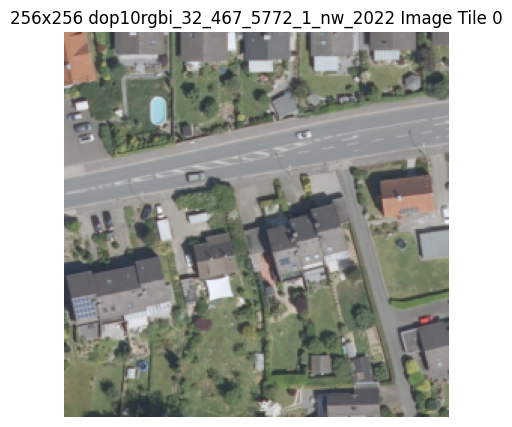

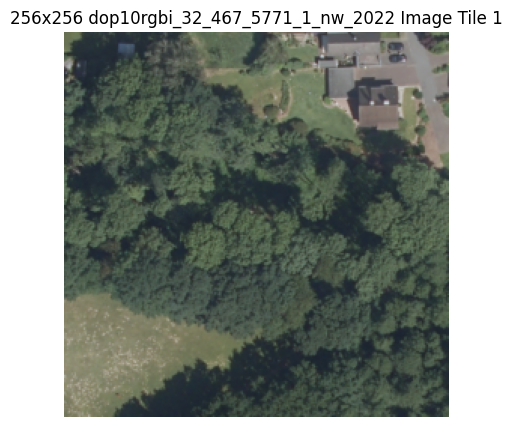

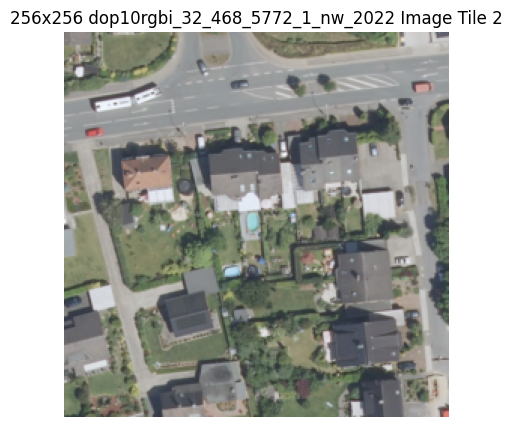

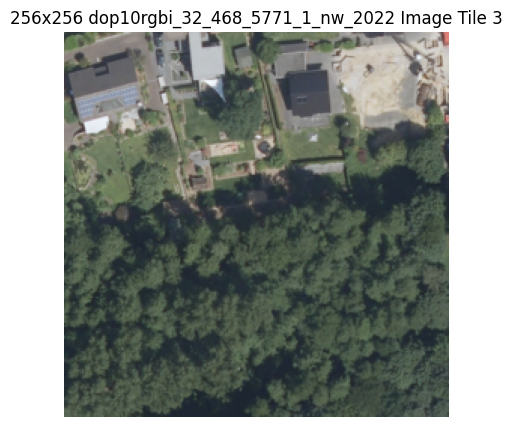

In [8]:
for iter, tile_image in enumerate(tile_image_paths):
    with rasterio.open(tile_image) as src:
        window = from_bounds(
            latitude_left,
            longitude_bottom,
            latitude_right,
            longitude_top,
            transform=src.transform,
        )

        partial_rgb = src.read([1, 2, 3], window=window)
        partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
        partial_rgb = np.clip(partial_rgb, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(partial_rgb, mode="RGB")
        pil_img_256 = pil_img.resize((256, 256), resample=Image.BILINEAR)

        # Plot the data
        plt.figure(figsize=(5, 5))
        plt.imshow(pil_img_256)
        plt.title(f"256x256 {tile_image.stem} Image Tile {iter}")
        plt.axis("off")
        plt.show()

I am so confused it just shows an image without any warnings. Did it work? Did it cut as i want magically? Let go to [https://epsg.io/](https://epsg.io/map#srs=25832&x=468002&y=5772002&z=18&layer=satellite) and check this point!

Looks actually exactly as I want! 

![Image from epsg.io (/docs/screenshot-468002-5772002.png)](./docs/screenshot-468002-5772002.png)

Okay it means mist probably I don't need to cut, handle Expection, deals with numpy etc - only on final stage! Really good! Lets concat these 4 images with **right** order and check the results.

I think i don't need to create complicated logic - I will look on files names and then just send my final bound box

In [9]:
log.info(tile_image_paths)

[2025-01-13 16:46:58,171] [INFO] [PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5771_1_nw_2022.jp2')]


In [10]:
log.info(f"latitude_left {latitude_left}, longitude_bottom {longitude_bottom}, latitude_right {latitude_right}, longitude_top {longitude_top}")

[2025-01-13 16:46:58,176] [INFO] latitude_left 467902, longitude_bottom 5771902, latitude_right 468102, longitude_top 5772102


Desired image box:

- latitude_left: **467902** (in image close to left side)
- longitude_bottom: **5771902** (more lower/bottom)
- latitude_right: **468102** ( not in)
- longitude_top: **5772600.0** (in the middle of image)

Dataset image jp2 bbox:

- latitude_left: **467000**
- longitude_bottom: **5772000**
- latitude_right: **467999**
- longitude_top: **5772999**

So bottom right compare to this jp2 image

In [111]:
with rasterio.open(tile_image_paths[0]) as src:
    window_1 = from_bounds(
        latitude_left,
        longitude_bottom,
        latitude_right,
        longitude_top,
        transform=src.transform
    )
    log.info(tile_image_paths[0].name)
    partial_rgb = src.read([1,2,3], window=window_1, boundless=True, fill_value=0)
    log.info(partial_rgb.shape)

    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_img0 = Image.fromarray(partial_rgb, mode="RGB")
    partial_img0.show()

[2025-01-13 20:13:58,675] [INFO] dop10rgbi_32_467_5771_1_nw_2022.jp2
[2025-01-13 20:13:59,918] [INFO] (3, 2000, 2000)


In [106]:
tile_image_paths.sort()
with rasterio.open(tile_image_paths[1]) as src:
    window_2 = from_bounds(
        latitude_left,
        longitude_bottom,
        latitude_right,
        longitude_top,
        transform=src.transform
    )
    log.info(tile_image_paths[1].name)
    partial_rgb = src.read([1,2,3], window=window_2, boundless=True, fill_value=0)
    log.info(partial_rgb.shape)

    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_img1 = Image.fromarray(partial_rgb, mode="RGB")
    partial_img1.show()

[2025-01-13 20:11:40,079] [INFO] dop10rgbi_32_467_5772_1_nw_2022.jp2
[2025-01-13 20:11:42,380] [INFO] (3, 2000, 2000)


This works!

In [46]:
#concat vertical
dst = Image.new('RGB', (partial_img0.width, partial_img0.height + partial_img1.width))
dst.paste(partial_img0, (0, 0))
dst.paste(partial_img1, (0, partial_img1.height))

dst.show()

There are only 3 possible cases (if radious still not more than jp2 width, height):
- In the middle of dataset image - easy just crop
- On the border between 2 images - need to decide how to paste it (more right, top, bottom, below)
- On the corner of image - then i need to deal with 4 cut images and join them

In [ ]:



def concat_hortizontally(left_image, right_image):
    dst = Image.new("RGB", (left_image.width + right_image.width, left_image.height))
    dst.paste(left_image, (0, 0))
    dst.paste(right_image, (left_image.width, 0))
    return dst


def concat_vertically(top_image, bottom_image):
    dst = Image.new("RGB", (top_image.width, top_image.height + bottom_image.height))
    dst.paste(top_image, (0, 0))
    dst.paste(bottom_image, (0, top_image.height))
    return dst


def get_file_latitude_longitude(
    tile_image_path: pathlib.Path,
) -> Tuple[Latitude, Longitude]:
    pattern = r"dop10rgbi_32_(\d+)_(\d+)_1_nw_\d{4}\.jp2"
    match = re.match(pattern, tile_image_path.name)
    return (match.group(1), match.group(2))


def generate_tile_image(
    tile_bounding_box: Tuple[LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop],
    tile_image_path: pathlib.Path,
):
    log.info(f"Generating {tile_image_path.stem} tile image")
    with rasterio.open(tile_image_path) as src:
        window = from_bounds(
            *tile_bounding_box,
            transform=src.transform,
        )
        log.info(window)
        partial_rgb = src.read([1, 2, 3], window=window)
        log.info(partial_rgb.shape)

        partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
        return Image.fromarray(partial_rgb, mode="RGB")
    
def concat_two_tile_images(
        final_image_bounding_box: Tuple[LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop],
        tile_image_paths: List[pathlib.Path]
):
    first_tile_langitude, first_tile_longitude = get_file_latitude_longitude(tile_image_paths[0])
    second_tile_langitude, second_tile_longitude = get_file_latitude_longitude(tile_image_paths[1])

    if first_tile_langitude == second_tile_langitude:
        if first_tile_longitude < second_tile_longitude:
            return concat_vertically(
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[1])
            )
        else:
            return concat_vertically(
                generate_tile_image(final_image_bounding_box, tile_image_paths[1]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
            )
    elif first_tile_longitude ==  second_tile_longitude:
        if second_tile_langitude > first_tile_langitude:
            return concat_hortizontally(
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[1])
            )
        else:
            return concat_hortizontally(
                generate_tile_image(final_image_bounding_box, tile_image_paths[1]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
            )

In [132]:
# generate_tile_image([latitude_left, longitude_bottom, latitude_right, longitude_top,], tile_image_paths[0]).show()

This case becomes super complicated when there are missing images and I need to concat top left and bottom right images. Lets assume that I have everything and just concat nearest tiles. 

- In case of 1 image - return cut image
- In case of 2 image 
    - check file name if same latitude, different longitude - concat vertically
    - different latitude concat horizontally
- In case of 4 images 
    - concat 2 times horozontally first (different latitudes same differnt longitudes)
    - one time concat vertically 2 couple images

In case of radious more than 1000 - I have big problem - but this is another discussion

[2025-01-13 21:16:52,255] [INFO] Generating dop10rgbi_32_467_5772_1_nw_2022 tile image
[2025-01-13 21:16:52,260] [INFO] Window(col_off=np.float64(9020.0), row_off=np.float64(8980.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 21:16:54,486] [INFO] (3, 1020, 980)


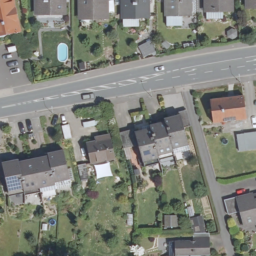

In [149]:
final_image_bounding_box = (latitude_left, longitude_bottom, latitude_right, longitude_top)
(
    generate_tile_image(final_image_bounding_box, tile_image_paths[1])
        .resize((256, 256), Image.BILINEAR)
)

[2025-01-13 21:16:25,878] [INFO] Generating dop10rgbi_32_468_5772_1_nw_2022 tile image
[2025-01-13 21:16:25,881] [INFO] Window(col_off=np.float64(-980.0), row_off=np.float64(8980.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 21:16:26,934] [INFO] (3, 1020, 1020)


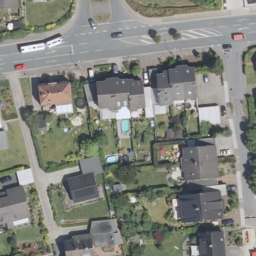

In [147]:
final_image_bounding_box = (latitude_left, longitude_bottom, latitude_right, longitude_top)
(
    
    generate_tile_image(final_image_bounding_box, tile_image_paths[3]).
        resize((256, 256), Image.BILINEAR)
)

In [ ]:
def generate_final_image(
    final_image_bounding_box: Tuple[
        LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop
    ],
    tile_image_paths: List[pathlib.Path],
) -> Image.Image:
    tile_image_paths.sort()  # just in case not necessary really bad - hidden affection on list

    if not tile_image_paths:
        # TODO @Karim: I need to consider case when I selected last image in dataset (e.g no image below and right).
        # So I need to create partial black image and concat with exist tiles.
        log.warning(
            "No tiles intersecting the bounding box. Returning a blank 256x256 image."
        )
        return Image.new("RGB", (256, 256), color="black")

    if len(tile_image_paths) == 1:
        return generate_tile_image(final_image_bounding_box, tile_image_paths[0])

    if len(tile_image_paths) == 2:
        return concat_two_tile_images(final_image_bounding_box, tile_image_paths)

    if len(tile_image_paths) == 4:
        _tile_image_paths = copy.deepcopy(tile_image_paths)
        return concat_vertically(
            concat_two_tile_images(
                final_image_bounding_box, [_tile_image_paths[1], _tile_image_paths[3]]
            ),
            concat_two_tile_images(
                final_image_bounding_box, [_tile_image_paths[0], _tile_image_paths[2]]
            ),
        )
    else:
        error_message = "I didn't implement other cases with missing images in dataset. Only when there is no found tile images at all"
        log.error(error_message)
        raise NotImplementedError(error_message)

In [143]:
image = generate_final_image(final_image_bounding_box, tile_image_paths)
image.resize((256, 256), Image.BILINEAR).show()

[2025-01-13 20:42:40,419] [INFO] Generating dop10rgbi_32_467_5772_1_nw_2022 tile image
[2025-01-13 20:42:40,423] [INFO] Window(col_off=np.float64(9020.0), row_off=np.float64(8980.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 20:42:42,669] [INFO] (3, 1020, 980)
[2025-01-13 20:42:42,682] [INFO] Generating dop10rgbi_32_468_5772_1_nw_2022 tile image
[2025-01-13 20:42:42,686] [INFO] Window(col_off=np.float64(-980.0), row_off=np.float64(8980.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 20:42:43,725] [INFO] (3, 1020, 1020)
[2025-01-13 20:42:43,740] [INFO] Generating dop10rgbi_32_467_5771_1_nw_2022 tile image
[2025-01-13 20:42:43,743] [INFO] Window(col_off=np.float64(9020.0), row_off=np.float64(-1020.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 20:42:44,906] [INFO] (3, 980, 980)
[2025-01-13 20:42:44,917] [INFO] Generating dop10rgbi_32_468_5771_1_nw_2022 tile image
[2025-01-13 20:42:44,920] [INFO] Window(col_off=np.float64(-

# Archive didn't work

In [ ]:

# def concat_two_nearest_images(
#     first_image_tile: pathlib.Path,
#     second_image_tile: pathlib.Path,
# ) -> Image.Image:
#     """Determines which concatenation function to use and whether to reverse the order of images.
    
#     Returns:
#     - Tuple:
#         1. Concatenation function: get_concat_vertically or get_concat_hortizontally.
#         2. Boolean flag: True if the order should be reversed, False otherwise.
    
#     """
#     (tile_left, tile_bottom, tile_right, tile_top) = tile_bounding_box
#     (final_left, final_bottom, final_right, final_top) = final_image_bounded_box

#     log.info(f"tile_bounding_box {tile_bounding_box}, \n final_image_bounded_box {final_image_bounded_box}")

#     log.info(f'Debug logic tile_top {tile_top} > or < final_top {final_top}?')
#     log.info(f'Debug logic tile_bottom {tile_bottom} > or < tile_bottom {final_bottom}?')
#     if final_top >= tile_bottom:
#         if final_left  <= tile_right:
#             return concat_hortizontally, False  # Tile is to the right of final image
#         elif tile_right == final_left:
#             return concat_hortizontally, True   # Tile is to the left of final image

#     # Check vertical alignment (top/bottom)
#     elif tile_left <= final_right and tile_right >= final_left:
#         # Tiles align horizontally (vertical concat)
#         if tile_top == final_bottom:  
#             return concat_vertically, False # Tile is below final image
#         elif tile_bottom == final_top:
#             return concat_vertically, True  # Tile is above final image

#     # If no alignment is found, raise an error
#     raise ValueError("Tile does not align with the final image bounding box.")

In [100]:
from rasterio.io import MemoryFile

radius = 100
mosaic_img = Image.new("RGB", (radius * 2, radius * 2), color=(0, 0, 0))

partial_images = []

tile_image_paths.sort()

window = from_bounds(
    left=latitude_left,
    bottom=longitude_bottom,
    right=latitude_right,
    top=longitude_top,
    transform=src.transform,
)

log.info(tile_image_paths)
for tile_path in tile_image_paths:
    try:
        with rasterio.open(tile_path) as src:
            # Create a window for the bounding box
            window = from_bounds(
                left=latitude_left,
                bottom=longitude_bottom,
                right=latitude_right,
                top=longitude_top,
                transform=src.transform,
            )

            # Partial read of 3 bands (RGB)
            partial_rgb = src.read(
                indexes=[1, 2, 3], window=window,
            )  # shape => (3, height, width)

            log.info(f"Partial rgb shape:{partial_rgb.shape}")
            # Build a snippet profile for an in-memory GeoTIFF
            snippet_profile = src.profile.copy()
            snippet_profile.update(
                {
                    "driver": "GTiff",
                    "height": partial_rgb.shape[1],
                    "width": partial_rgb.shape[2],
                    "count": 3,  # 3 bands
                    "transform": rasterio.windows.transform(window, src.transform),
                }
            )

            # 2) Write snippet to a MemoryFile
            with MemoryFile() as memfile:
                with memfile.open(**snippet_profile) as mem:
                    mem.write(partial_rgb)

                # 3) Reopen from memory & read for PIL conversion
                with memfile.open() as reopened:
                    snippet_data = reopened.read()  # shape => (3, h, w)
                    snippet_data = np.transpose(snippet_data, (1, 2, 0))  # => (h, w, 3)
                    snippet_data = np.clip(snippet_data, 0, 255).astype(np.uint8)
                    snippet_img = Image.fromarray(snippet_data, "RGB")

            # Keep the snippet as a PIL image
            partial_images.append(snippet_img)
            log.info(f"Successfully read partial snippet from {tile_path}")
    except Exception as e:
        log.error(f"Error reading partial snippet from {tile_path}: {e}")
        partial_images.append(Image.new("RGB", (10, 10), color="black"))

if not partial_images:
    log.warning("No partial images found. Showing a blank image.")
    blank_img = Image.new("RGB", (256, 256), "black")
    blank_img.show()
else:
    # Calculate total mosaic width = sum of snippet widths
    # Height = max snippet height
    widths = [img.width for img in partial_images]
    heights = [img.height for img in partial_images]
    mosaic_width = sum(widths)
    mosaic_height = max(heights) if heights else 0

    mosaic_img = Image.new("RGB", (mosaic_width, mosaic_height), color="black")

    x_offset = 0
    for img in partial_images:
        mosaic_img.paste(img, (x_offset, 0))
        x_offset += img.width

    # 5) Optionally resize & show
    # final_img = mosaic_img.resize((256, 256), Image.BILINEAR)
    mosaic_img.show()

[2025-01-13 19:45:48,883] [INFO] [PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5771_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2')]
[2025-01-13 19:45:50,121] [INFO] Partial rgb shape:(3, 980, 980)
[2025-01-13 19:45:50,138] [INFO] Successfully read partial snippet from /Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2
[2025-01-13 19:45:52,360] [INFO] Partial rgb shape:(3, 1020, 980)
[2025-01-13 19:45:52,377] [INFO] Successfully read partial snippet from /Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2
[2025

In [97]:
tile_image_paths.sort()

In [98]:
tile_image_paths

[PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2'),
 PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2'),
 PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5771_1_nw_2022.jp2'),
 PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2')]

In [99]:
from rasterio.transform import from_bounds as transform_from_bounds
from rasterio.windows import from_bounds, bounds

mosaic_left = latitude_left
mosaic_top = longitude_top
mosaic_right = latitude_right
mosaic_bottom = longitude_bottom

# We’ll read resolution from the first tile in the list:
with rasterio.open(tile_image_paths[0]) as src0:
    # Typically transform[0] is pixel width, transform[4] is pixel height (negative)
    xres = abs(src0.transform[0])
    yres = abs(src0.transform[4])

# Compute pixel dimensions for the big mosaic
mosaic_width = int((mosaic_right - mosaic_left) / xres)
mosaic_height = int((mosaic_top - mosaic_bottom) / yres)

log.info(f"mosaic_width {mosaic_width} mosaic_height {mosaic_height}")
# Create a black PIL image for the final mosaic
mosaic_img = Image.new("RGB", (mosaic_width, mosaic_height), color=(0, 0, 0))


# Build the mosaic transform.
# NOTE: from_bounds expects order: left, top, right, bottom if we want a typical "north up".
# If your data are different, you may need to switch top/bottom.
mosaic_transform = transform_from_bounds(
    mosaic_left,
    mosaic_top,      # <-- top
    mosaic_right,
    mosaic_bottom,   # <-- bottom
    mosaic_width,
    mosaic_height,
)

partial_images = []
for tile_path in tile_image_paths:
    with rasterio.open(tile_path) as src:
        # Build a window for the user’s area-of-interest (the user bounding box).
        # "latitude_left", "longitude_bottom", etc. might be better called "x_left", "y_bottom" in EPSG:25832
        window = from_bounds(
            left=latitude_left,
            bottom=longitude_bottom,
            right=latitude_right,
            top=longitude_top,
            transform=src.transform,
        )

        # Read the 3-band snippet.  NO boundless, no fill_value => we only get actual image data
        partial_rgb = src.read(indexes=[1, 2, 3], window=window)
        if partial_rgb.size == 0:
            # This means there's no overlap or no data in this window
            continue
        
        # Get the bounding box of this snippet in EPSG:25832
        snippet_bounds = bounds(window, src.transform)  # -> (left, bottom, right, top)
        log.info(snippet_bounds)
        # Convert the snippet’s top-left corner from EPSG:25832 coords to mosaic row/col
        # snippet top-left in world space = (snippet_bounds.left, snippet_bounds.top)
        row_top, col_left = ~mosaic_transform * (snippet_bounds[0], snippet_bounds[1])
        
        # PIL expects (x=col, y=row)
        paste_x = int(round(col_left))
        paste_y = int(round(row_top))
        
        # Convert partial to a PIL Image
        # partial_rgb shape => (3, height, width). We want => (height, width, 3).
        snippet_data = np.transpose(partial_rgb, (1, 2, 0)).astype(np.uint8)
        snippet_img = Image.fromarray(snippet_data, mode="RGB")
        snippet_img.show()
        # Finally, paste at the correct location
        mosaic_img.paste(snippet_img, (paste_x, paste_y))

# -------------------------------------------------------
# 3) Show the final mosaic in the notebook
# -------------------------------------------------------
mosaic_img.show()

[2025-01-13 19:45:21,794] [INFO] mosaic_width 2000 mosaic_height 2000
[2025-01-13 19:45:23,096] [INFO] (np.float64(467902.0), np.float64(5771902.0), np.float64(468102.0), np.float64(5772102.0))
[2025-01-13 19:45:25,579] [INFO] (np.float64(467902.0), np.float64(5771902.0), np.float64(468102.0), np.float64(5772102.0))
[2025-01-13 19:45:26,362] [INFO] (np.float64(467902.0), np.float64(5771902.0), np.float64(468102.0), np.float64(5772102.0))
[2025-01-13 19:45:27,705] [INFO] (np.float64(467902.0), np.float64(5771902.0), np.float64(468102.0), np.float64(5772102.0))
